In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
train_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/RTIOT_train_2labels.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/RTIOT/Datasets/RTIOT_test_2labels.pkl')

In [5]:
train_df = train_df.drop(['proto'], axis=1)
train_df = train_df.drop(['service'], axis=1)
train_df = train_df.drop(['id.orig_p'], axis=1)
train_df = train_df.drop(['id.resp_p'], axis=1)
test_df = test_df.drop(['proto'], axis=1)
test_df = test_df.drop(['service'], axis=1)
test_df = test_df.drop(['id.orig_p'], axis=1)
test_df = test_df.drop(['id.resp_p'], axis=1)


In [6]:
test_df = test_df.reset_index(drop=True)
test_df

,id.orig_p,id.resp_p,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack,is_Normal
0,46774,53,0.027133,2,2,2,2,7.371101e+01,7.371101e+01,1.474220e+02,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0,0,0,False,True
1,68,67,100.475928,10,0,10,0,9.952600e-02,0.000000e+00,9.952600e-02,...,9.040719e+06,35599052.91,93022574.90,23255643.73,1.184459e+07,0,0,0,True,False
2,54326,53,0.000315,2,2,2,2,6.350195e+03,6.350195e+03,1.270039e+04,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0,0,0,True,False
3,30032,21,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
4,62419,21,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24619,3463,21,0.000002,1,1,1,0,4.660338e+05,4.660338e+05,9.320676e+05,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
24620,31823,21,0.000004,1,1,1,0,2.467238e+05,2.467238e+05,4.934475e+05,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
24621,3664,21,0.000001,1,1,1,0,1.048576e+06,1.048576e+06,2.097152e+06,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False
24622,27179,21,0.000005,1,1,1,0,1.997288e+05,1.997288e+05,3.994575e+05,...,0.000000e+00,0.00,0.00,0.00,0.000000e+00,64,0,64,True,False


In [ ]:
train_normal_data = train_df[train_df['is_Normal'] == True]
train_normal_data = train_normal_data.drop('is_Attack', axis=1)
train_normal_data

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
0,3.492611,14,13,6,5,4.008462,3.722144,7.730606,0.928571,468,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,74,True
1,0.024602,2,2,2,2,81.294414,81.294414,162.588828,1.000000,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
2,0.026130,2,2,2,2,76.540489,76.540489,153.080978,1.000000,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
3,0.025820,1,1,1,1,38.729642,38.729642,77.459283,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
4,1.179449,6,4,1,1,5.087121,3.391414,8.478535,0.666667,200,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,60,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444217,0.000152,1,1,1,1,6574.144201,6574.144201,13148.288400,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
444218,0.301341,9,12,3,7,29.866491,39.821988,69.688479,1.333333,296,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402,True
444219,0.026886,1,1,1,1,37.194098,37.194098,74.388195,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
444220,0.284752,10,13,3,8,35.118262,45.653741,80.772003,1.300000,328,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402,True


In [ ]:
train_normal_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/train_normal.pkl")

In [ ]:
X_train = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/train_normal.pkl")
X_train

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
0,3.492611,14,13,6,5,4.008462,3.722144,7.730606,0.928571,468,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,74,True
1,0.024602,2,2,2,2,81.294414,81.294414,162.588828,1.000000,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
2,0.026130,2,2,2,2,76.540489,76.540489,153.080978,1.000000,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
3,0.025820,1,1,1,1,38.729642,38.729642,77.459283,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
4,1.179449,6,4,1,1,5.087121,3.391414,8.478535,0.666667,200,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,60,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444217,0.000152,1,1,1,1,6574.144201,6574.144201,13148.288400,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
444218,0.301341,9,12,3,7,29.866491,39.821988,69.688479,1.333333,296,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402,True
444219,0.026886,1,1,1,1,37.194098,37.194098,74.388195,1.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
444220,0.284752,10,13,3,8,35.118262,45.653741,80.772003,1.300000,328,...,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402,True


In [ ]:
X_train = X_train.drop('is_Normal', axis=1)
X_train

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,3.492611,14,13,6,5,4.008462,3.722144,7.730606,0.928571,468,...,3.492634e+06,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,74
1,0.024602,2,2,2,2,81.294414,81.294414,162.588828,1.000000,16,...,2.460194e+04,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,0.026130,2,2,2,2,76.540489,76.540489,153.080978,1.000000,16,...,2.612996e+04,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,0.025820,1,1,1,1,38.729642,38.729642,77.459283,1.000000,8,...,2.582002e+04,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,1.179449,6,4,1,1,5.087121,3.391414,8.478535,0.666667,200,...,1.179462e+06,0.0,0.0,0.0,0.0,0.0,0.0,29200,65535,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444217,0.000152,1,1,1,1,6574.144201,6574.144201,13148.288400,1.000000,8,...,1.521111e+02,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
444218,0.301341,9,12,3,7,29.866491,39.821988,69.688479,1.333333,296,...,3.013411e+05,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402
444219,0.026886,1,1,1,1,37.194098,37.194098,74.388195,1.000000,8,...,2.688599e+04,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
444220,0.284752,10,13,3,8,35.118262,45.653741,80.772003,1.300000,328,...,2.847521e+05,0.0,0.0,0.0,0.0,0.0,0.0,29200,65160,402


In [ ]:
test_normal_data = test_df[test_df['is_Normal'] == True]
test_normal_data = test_normal_data.drop('is_Attack', axis=1)
test_normal_data

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
1,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
2,0.026567,2,2,2,2,75.281414,75.281414,150.562829,1.000000,16,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
3,0.033777,1,1,1,1,29.605946,29.605946,59.211892,1.000000,8,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
4,0.023762,1,1,1,1,42.084021,42.084021,84.168043,1.000000,8,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
5,0.319120,9,12,3,7,28.202563,37.603418,65.805981,1.333333,296,...,0.0,0.00,0.0,0.0,0.00,0.000000,29200,65160,402,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111050,0.000076,1,1,0,0,13189.635220,13189.635220,26379.270440,1.000000,40,...,0.0,0.00,0.0,0.0,0.00,0.000000,29200,0,29200,True
111051,0.027677,2,2,2,2,72.262013,72.262013,144.524025,1.000000,16,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
111052,0.023514,1,1,1,1,42.527797,42.527797,85.055594,1.000000,8,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
111053,119.993840,3,0,3,0,0.025001,0.000000,0.025001,0.000000,24,...,0.0,59996471.88,59997368.1,119993840.0,59996919.99,633.720014,0,0,0,True


In [ ]:
test_normal_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/test_normal.pkl")

In [ ]:
X_test = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/test_normal.pkl")
X_test

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Normal
1,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
2,0.026567,2,2,2,2,75.281414,75.281414,150.562829,1.000000,16,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
3,0.033777,1,1,1,1,29.605946,29.605946,59.211892,1.000000,8,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
4,0.023762,1,1,1,1,42.084021,42.084021,84.168043,1.000000,8,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
5,0.319120,9,12,3,7,28.202563,37.603418,65.805981,1.333333,296,...,0.0,0.00,0.0,0.0,0.00,0.000000,29200,65160,402,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111050,0.000076,1,1,0,0,13189.635220,13189.635220,26379.270440,1.000000,40,...,0.0,0.00,0.0,0.0,0.00,0.000000,29200,0,29200,True
111051,0.027677,2,2,2,2,72.262013,72.262013,144.524025,1.000000,16,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
111052,0.023514,1,1,1,1,42.527797,42.527797,85.055594,1.000000,8,...,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0,True
111053,119.993840,3,0,3,0,0.025001,0.000000,0.025001,0.000000,24,...,0.0,59996471.88,59997368.1,119993840.0,59996919.99,633.720014,0,0,0,True


In [ ]:
X_test = X_test.drop('is_Normal', axis=1)
X_test

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
1,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,...,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0
2,0.026567,2,2,2,2,75.281414,75.281414,150.562829,1.000000,16,...,26566.982270,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0
3,0.033777,1,1,1,1,29.605946,29.605946,59.211892,1.000000,8,...,33776.998520,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0
4,0.023762,1,1,1,1,42.084021,42.084021,84.168043,1.000000,8,...,23761.987690,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0
5,0.319120,9,12,3,7,28.202563,37.603418,65.805981,1.333333,296,...,319119.930300,0.0,0.00,0.0,0.0,0.00,0.000000,29200,65160,402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111050,0.000076,1,1,0,0,13189.635220,13189.635220,26379.270440,1.000000,40,...,75.817108,0.0,0.00,0.0,0.0,0.00,0.000000,29200,0,29200
111051,0.027677,2,2,2,2,72.262013,72.262013,144.524025,1.000000,16,...,27677.059170,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0
111052,0.023514,1,1,1,1,42.527797,42.527797,85.055594,1.000000,8,...,23514.032360,0.0,0.00,0.0,0.0,0.00,0.000000,0,0,0
111053,119.993840,3,0,3,0,0.025001,0.000000,0.025001,0.000000,24,...,0.000000,0.0,59996471.88,59997368.1,119993840.0,59996919.99,633.720014,0,0,0


In [ ]:
# Encode labels and scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
X_train.shape

torch.Size([414066, 79])

In [ ]:
X_test.shape

torch.Size([103516, 79])

In [ ]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(79, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 79),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Initialize the autoencoder
model = AE().to(device)

# Loss function and optimizer
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=79, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=79, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
# Convert the data to DataLoader
# train_loader = DataLoader(X_train, batch_size=len(X_train), shuffle=True)
# test_loader = DataLoader(X_test, batch_size=len(X_test), shuffle=True)

AUTOENCODER RECONSTRUCTION LOSS

Epoch 50/1000, Train Loss: 0.1642247885465622
Epoch 100/1000, Train Loss: 0.011921191588044167
Epoch 150/1000, Train Loss: 0.009715022519230843
Epoch 200/1000, Train Loss: 0.008713423274457455
Epoch 250/1000, Train Loss: 0.00653156777843833
Epoch 300/1000, Train Loss: 0.003746472531929612
Epoch 350/1000, Train Loss: 0.0031820458825677633
Epoch 400/1000, Train Loss: 0.002909194678068161
Epoch 450/1000, Train Loss: 0.0026313215494155884
Epoch 500/1000, Train Loss: 0.0024225907400250435
Epoch 550/1000, Train Loss: 0.0022955809254199266
Epoch 600/1000, Train Loss: 0.0020493813790380955
Epoch 650/1000, Train Loss: 0.00186429382301867
Epoch 700/1000, Train Loss: 0.001729774521663785
Epoch 750/1000, Train Loss: 0.0015390507178381085
Epoch 800/1000, Train Loss: 0.001476452685892582
Epoch 850/1000, Train Loss: 0.0014333553845062852
Epoch 900/1000, Train Loss: 0.0013759653083980083
Epoch 950/1000, Train Loss: 0.0012772106565535069
Epoch 1000/1000, Train Loss: 0.0

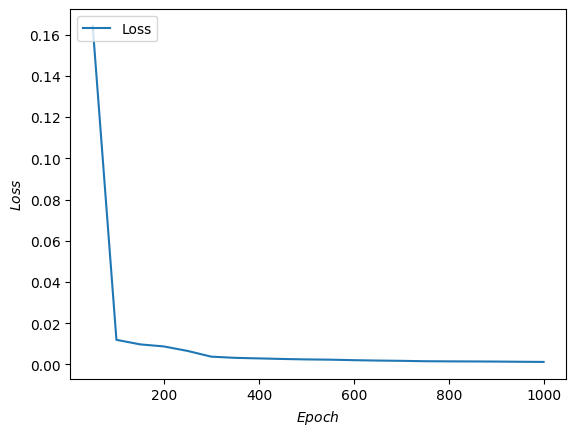

In [ ]:
# Training the Autoencoder
model.train()

x_axis = []
y_axis = []

outputs = []
epochs = 1000

print("AUTOENCODER RECONSTRUCTION LOSS\n")
for epoch in range(epochs):
  # for idx, data in enumerate(train_loader):
    # x_train = data[0].to(device)

    optimizer.zero_grad()
    pred = model(X_train).to(device)
    loss = criterion(pred, X_train).to(device)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
      x_axis.append(epoch)
      y_axis.append(loss.item())
      print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}')

fig, x1 = plt.subplots()
x1.set_xlabel('$Epoch$')
x1.set_ylabel('$Loss$')
x1.plot(x_axis, y_axis, label="Loss")
x1.legend(loc='upper left')
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/ModelSaving/AE_HIKARI.pth")

In [ ]:
new_model = AE().to(device)

In [ ]:
new_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/ModelSaving/AE_HIKARI.pth"))

<All keys matched successfully>

In [ ]:
# Evaluate the Autoencoder on Test Data

model.eval()

with torch.no_grad():
  n = len(X_test)
  print("Size of n: ", len(X_test))
  reconstructed = new_model(X_test).to(device)
  # normal_loss = torch.sum((X_test - reconstructed) ** 2, dim=1)
  normal_loss = (torch.sum(abs(X_test - reconstructed) ** 2, dim=1)) / len(X_test)

normal_loss_np = normal_loss.cpu().numpy()  # Convert to numpy array
normal_loss_np = normal_loss_np.reshape(-1)
# print("AUTOENCODER RECONSTRUCTION LOSS\n")
# print(f'Test Loss: {loss.item():}')
print("Reconstruction normal error: ", normal_loss_np)
print("Reconstruction normal error percentile: ", np.percentile(normal_loss_np, [0, 25, 50, 75, 90, 95, 99]))
print("Size of normal loss: ", normal_loss_np.size)

Size of n:  103516
Reconstruction normal error:  [6.3049418e-07 5.7375026e-08 4.7440015e-08 ... 5.5321063e-08 1.8025003e-05
 4.3892490e-07]
Reconstruction normal error percentile:  [4.62428034e-08 5.61271989e-08 2.05670041e-07 5.28957671e-07
 1.43387427e-06 3.81583163e-06 1.79412766e-05]
Size of normal loss:  103516


In [ ]:
print(format(np.percentile(normal_loss_np, [99])))

[1.79412766e-05]


In [ ]:
# Load the attack data
test_attack_data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/Hikari_test_2labels.pkl')
test_attack_data

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack,is_Normal
0,0.357034,9,12,3,7,25.207686,33.610247,58.817933,1.333333,296,...,0.00,0.0,0.0,0.00,0.000000,29200,65160,402,True,False
1,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,...,0.00,0.0,0.0,0.00,0.000000,0,0,0,False,True
2,0.026567,2,2,2,2,75.281414,75.281414,150.562829,1.000000,16,...,0.00,0.0,0.0,0.00,0.000000,0,0,0,False,True
3,0.033777,1,1,1,1,29.605946,29.605946,59.211892,1.000000,8,...,0.00,0.0,0.0,0.00,0.000000,0,0,0,False,True
4,0.023762,1,1,1,1,42.084021,42.084021,84.168043,1.000000,8,...,0.00,0.0,0.0,0.00,0.000000,0,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111051,0.027677,2,2,2,2,72.262013,72.262013,144.524025,1.000000,16,...,0.00,0.0,0.0,0.00,0.000000,0,0,0,False,True
111052,0.023514,1,1,1,1,42.527797,42.527797,85.055594,1.000000,8,...,0.00,0.0,0.0,0.00,0.000000,0,0,0,False,True
111053,119.993840,3,0,3,0,0.025001,0.000000,0.025001,0.000000,24,...,59996471.88,59997368.1,119993840.0,59996919.99,633.720014,0,0,0,False,True
111054,0.230230,10,13,3,8,43.434853,56.465310,99.900163,1.300000,328,...,0.00,0.0,0.0,0.00,0.000000,29200,65160,402,True,False


In [ ]:
test_attack_data = test_df[test_df['is_Attack'] == True]
test_attack_data = test_attack_data.drop('is_Normal', axis=1)
test_attack_data = test_attack_data.reset_index(drop=True)

In [ ]:
test_attack_data.to_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/test_attack.pkl")

In [ ]:
X_test_attack = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/MITA 2024/HIKARI 2021/Datasets/test_attack.pkl")
X_test_attack

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,is_Attack
0,0.357034,9,12,3,7,25.207686,33.610247,58.817933,1.333333,296,...,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402,True
1,7.153523,13,13,6,4,1.817286,1.817286,3.634573,1.000000,412,...,302313.6124,6.670371e+06,6.670371e+06,6.670371e+06,6.670371e+06,0.0,29200,65160,0,True
2,2.238758,15,14,6,6,6.700144,6.253468,12.953612,0.933333,488,...,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,True
3,6.730588,15,14,6,6,2.228631,2.080056,4.308687,0.933333,488,...,150620.0239,6.461417e+06,6.461417e+06,6.461417e+06,6.461417e+06,0.0,29200,65160,0,True
4,11.532148,15,14,6,6,1.300712,1.213998,2.514709,0.933333,464,...,284843.7437,1.107336e+07,1.107336e+07,1.107336e+07,1.107336e+07,0.0,29200,65160,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,4.099786,43,38,9,31,10.488352,9.268776,19.757129,0.883721,1528,...,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,28960,0,True
7536,0.356221,9,12,3,7,25.265217,33.686956,58.952174,1.333333,296,...,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402,True
7537,0.271308,10,13,3,8,36.858486,47.916031,84.774517,1.300000,328,...,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402,True
7538,7.018991,23,16,6,12,3.276824,2.279530,5.556354,0.695652,756,...,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,28960,0,True


In [ ]:
X_test_attack = X_test_attack.drop('is_Attack', axis=1)
X_test_attack

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,0.357034,9,12,3,7,25.207686,33.610247,58.817933,1.333333,296,...,3.570340e+05,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402
1,7.153523,13,13,6,4,1.817286,1.817286,3.634573,1.000000,412,...,2.415760e+05,302313.6124,6.670371e+06,6.670371e+06,6.670371e+06,6.670371e+06,0.0,29200,65160,0
2,2.238758,15,14,6,6,6.700144,6.253468,12.953612,0.933333,488,...,2.238776e+06,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0
3,6.730588,15,14,6,6,2.228631,2.080056,4.308687,0.933333,488,...,1.345966e+05,150620.0239,6.461417e+06,6.461417e+06,6.461417e+06,6.461417e+06,0.0,29200,65160,0
4,11.532148,15,14,6,6,1.300712,1.213998,2.514709,0.933333,464,...,2.294010e+05,284843.7437,1.107336e+07,1.107336e+07,1.107336e+07,1.107336e+07,0.0,29200,65160,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,4.099786,43,38,9,31,10.488352,9.268776,19.757129,0.883721,1528,...,4.099814e+06,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,28960,0
7536,0.356221,9,12,3,7,25.265217,33.686956,58.952174,1.333333,296,...,3.562210e+05,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402
7537,0.271308,10,13,3,8,36.858486,47.916031,84.774517,1.300000,328,...,2.713079e+05,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,402
7538,7.018991,23,16,6,12,3.276824,2.279530,5.556354,0.695652,756,...,7.047733e+06,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,28960,0


In [ ]:
# Scale the anomalous data
X_test_attack = scaler.transform(X_test_attack)

# Convert to PyTorch tensors
X_test_attack = torch.tensor(X_test_attack, dtype=torch.float).to(device)

In [ ]:
# Compute Reconstruction Errors for anomaly Data

with torch.no_grad():
  # n = len(X_test_attack)
  reconstructed_attack = new_model(X_test_attack).to(device)
  # attack_loss = torch.sum((X_test_attack - reconstructed_attack) ** 2, dim=1)
  attack_loss = (torch.sum(abs(X_test_attack - reconstructed_attack) ** 2, dim=1)) / len(X_test_attack)

attack_loss_np = attack_loss.cpu().numpy()  # Convert to numpy array
attack_loss_np = attack_loss_np.reshape(-1)
print("Reconstruction attack error: ", attack_loss_np)
print("Reconstruction attack error percentile: ", np.percentile(attack_loss.cpu(), [0, 25, 50, 75, 90, 95, 99]))
print("Size of attack loss: ", attack_loss_np.size)

Reconstruction attack error:  [6.6191501e-06 7.7786117e-06 7.0608094e-06 ... 2.0642412e-06 8.4631511e-06
 2.0667517e-06]
Reconstruction attack error percentile:  [1.91180629e-06 3.20630886e-06 5.40472797e-06 8.07604147e-06
 1.19944609e-05 2.00718480e-05 1.50466714e-04]
Size of attack loss:  7540


In [ ]:
print(format(np.percentile(attack_loss_np, [99])))

[0.00015047]


In [ ]:
# # Compute Reconstruction Errors for Normal Data (Test Data)

# with torch.no_grad():
#   reconstructed_normal = new_model(X_test).to(device)
#   normal_loss = torch.sum((X_test - reconstructed_normal) ** 2, dim=1)
# normal_loss_np = normal_loss.cpu().numpy()  # Convert to numpy array
# normal_loss_np = normal_loss_np.reshape(-1)
# print("Reconstruction normal error: ", np.percentile(normal_loss_np, [0, 25, 50, 75, 90, 95, 99]))
# print("Reconstruction normal error: ", normal_loss_np)
# print("Size of normal loss: ", normal_loss_np.size)

In [ ]:
# print(format(3.11301911e+00))

Text(0.5, 0, 'Index')

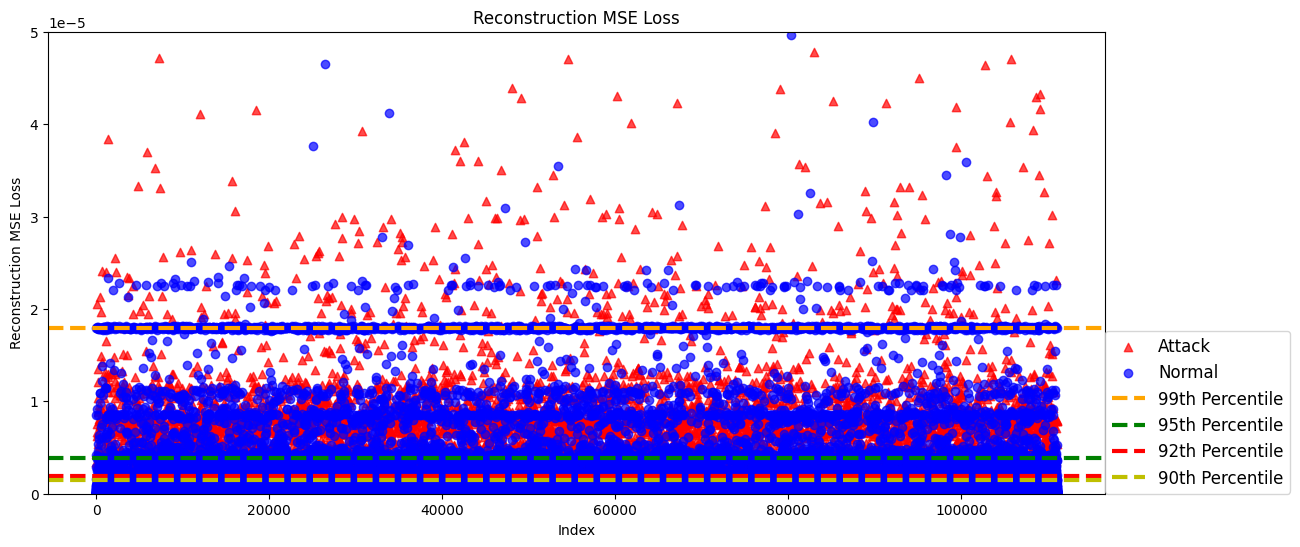

In [ ]:
loss_df = pd.DataFrame()
loss_df['Class'] = [0] * len(normal_loss_np) + [1] * len(attack_loss_np)
loss_df['MSELoss'] = np.hstack([normal_loss_np, attack_loss_np])
loss_df = loss_df.sample(frac=1.0).reset_index(drop=True)

markers = ['o', '^']
markers = ['o', '^']
colors = ['blue', 'red']
labels = ['Normal', 'Attack']

plt.figure(figsize=(30, 6))
plt.subplot(121)
for flag in [1, 0]:
    temp = loss_df[loss_df['Class'] == flag]
    plt.scatter(temp.index,
                temp['MSELoss'],
                alpha=0.7,
                marker=markers[flag],
                c=colors[flag],
                label=labels[flag])
plt.axhline(y=np.percentile(normal_loss_np, [99]), color='orange', linewidth=3, linestyle='--', label='99th Percentile')
plt.axhline(y=np.percentile(normal_loss_np, [95]), color='g', linewidth=3, linestyle='--', label='95th Percentile')
plt.axhline(y=np.percentile(normal_loss_np, [92]), color='r', linewidth=3, linestyle='--', label='92th Percentile')
plt.axhline(y=np.percentile(normal_loss_np, [90]), color='y', linewidth=3, linestyle='--', label='90th Percentile')

plt.ylim(0, 0.00005)
plt.legend(loc=[1, 0], fontsize=12)
plt.title('Reconstruction MSE Loss')
plt.ylabel('Reconstruction MSE Loss')
plt.xlabel('Index')

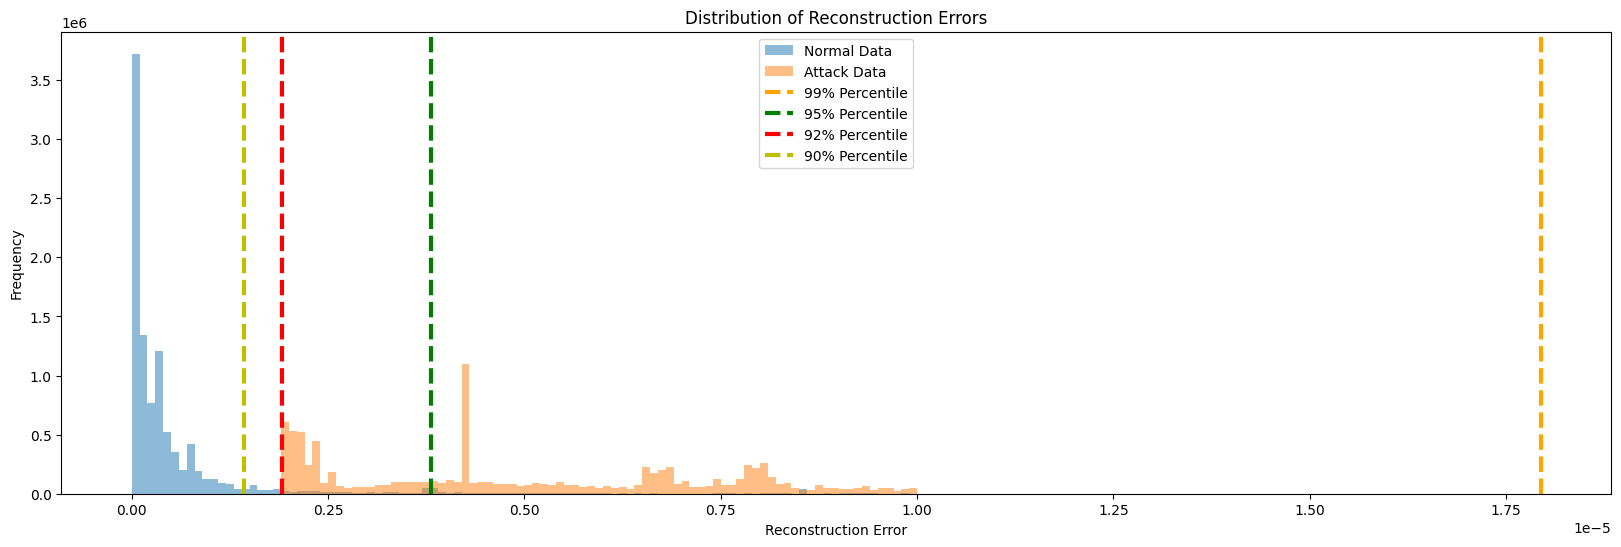

Threshold at 90th percentile: 1.4338742744257615e-06
Threshold at 95th percentile: 3.815831632891786e-06
Threshold at 99th percentile: 1.794127656467026e-05
Mean Reconstruction Error for Normal Data: 9.265402809432999e-07
Standard Deviation for Normal Data: 2.9952552722534165e-06


In [ ]:
# Plotting histograms of reconstruction errors
plt.figure(figsize=(20, 6))
plt.hist(normal_loss_np, bins=100, alpha=0.5, range=[0, 0.00001], histtype='stepfilled', density=True, label='Normal Data')
plt.hist(attack_loss_np, bins=100, alpha=0.5, range=[0, 0.00001], histtype='stepfilled', density=True, label='Attack Data')
plt.axvline(x=np.percentile(normal_loss_np, [99]), color='orange', linewidth=3, linestyle='--', label='99% Percentile')
plt.axvline(x=np.percentile(normal_loss_np, [95]), color='g', linewidth=3, linestyle='--', label='95% Percentile')
plt.axvline(x=np.percentile(normal_loss_np, [92]), color='r', linewidth=3, linestyle='--', label='92% Percentile')
plt.axvline(x=np.percentile(normal_loss_np, [90]), color='y', linewidth=3, linestyle='--', label='90% Percentile')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

# Using Percentiles to determine threshold
percentiles = [90, 95, 99]
for p in percentiles:
    threshold = np.percentile(normal_loss_np, p)
    print(f"Threshold at {p}th percentile: {threshold:}")

# Additional statistical analysis (Optional)
mean_normal = np.mean(normal_loss_np)
std_normal = np.std(normal_loss_np)
print(f"Mean Reconstruction Error for Normal Data: {mean_normal:}")
print(f"Standard Deviation for Normal Data: {std_normal:}")

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the threshold as the 95th percentile of normal reconstruction errors
threshold = np.percentile(normal_loss_np, 92) #Threshold for classification
print("threshold:", threshold)

# Classify as attack if reconstruction error exceeds the threshold

# y_pred_test = torch.sum((X_test - reconstructed_normal) ** 2, axis=1) > threshold
# y_pred_anomalous = torch.sum((X_test_attack - reconstructed_attack) ** 2, axis=1) > threshold
# y_pred_test = (X_test-reconstructed).pow(2).sum(1) > threshold
# y_pred_anomalous = (X_test_attack - reconstructed_attack).pow(2).sum(1) > threshold
y_pred_test = (torch.sum(abs(X_test - reconstructed) ** 2, dim=1) / len(X_test)) > threshold
y_pred_anomalous = (torch.sum(abs(X_test_attack - reconstructed_attack)**2, dim=1) / len(X_test_attack)) > threshold

y_pred_test = y_pred_test.cpu()
y_pred_anomalous = y_pred_anomalous.cpu()

# True labels: 0 for normal, 1 for attack
y_true_test = np.zeros(len(y_pred_test))
y_true_anomalous = np.ones(len(y_pred_anomalous))

# Combine predictions and true labels
y_pred_combined = np.concatenate([y_pred_test.numpy(), y_pred_anomalous.numpy()])
y_true_combined = np.concatenate([y_true_test, y_true_anomalous])

# Calculate accuracy
accuracy = accuracy_score(y_true_combined, y_pred_combined)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_combined, y_pred_combined)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


threshold: 1.9131741737510323e-06
Accuracy: 0.9254
Confusion Matrix:
[[95234  8282]
 [    2  7538]]


In [ ]:
from sklearn.metrics import classification_report

target_names = ['Normal', 'Attack']
print(classification_report(y_true_combined, y_pred_combined, target_names=target_names, digits=4))
print(confusion_matrix(y_true_combined, y_pred_combined))

              precision    recall  f1-score   support

      Normal     1.0000    0.9200    0.9583    103516
      Attack     0.4765    0.9997    0.6454      7540

    accuracy                         0.9254    111056
   macro avg     0.7382    0.9599    0.8018    111056
weighted avg     0.9644    0.9254    0.9371    111056

[[95234  8282]
 [    2  7538]]
